# **Cats vs Dogs**

Setup

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os

# *TPU Strategy*

In [2]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)

strategy = tf.distribute.TPUStrategy(cluster_resolver)

# Load Data

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  55.7M      0  0:00:14  0:00:14 --:--:-- 78.5M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [5]:
!ls PetImages

Cat  Dog


# Filter out Corrupted Images

In [7]:
total_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        try:
            fileobj = open(filepath, 'rb')
            is_jfif = b'JFIF' in fileobj.peek(10)
        finally:
            fileobj.close()

        if not is_jfif:
            total_skipped += 1
            os.remove(filepath)

print('Deleted ', total_skipped, ' images.')

Deleted  1590  images.


# Generate a Dataset

In [8]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    'PetImages',
    validation_split=0.2,
    subset='both',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


# Visualize the data

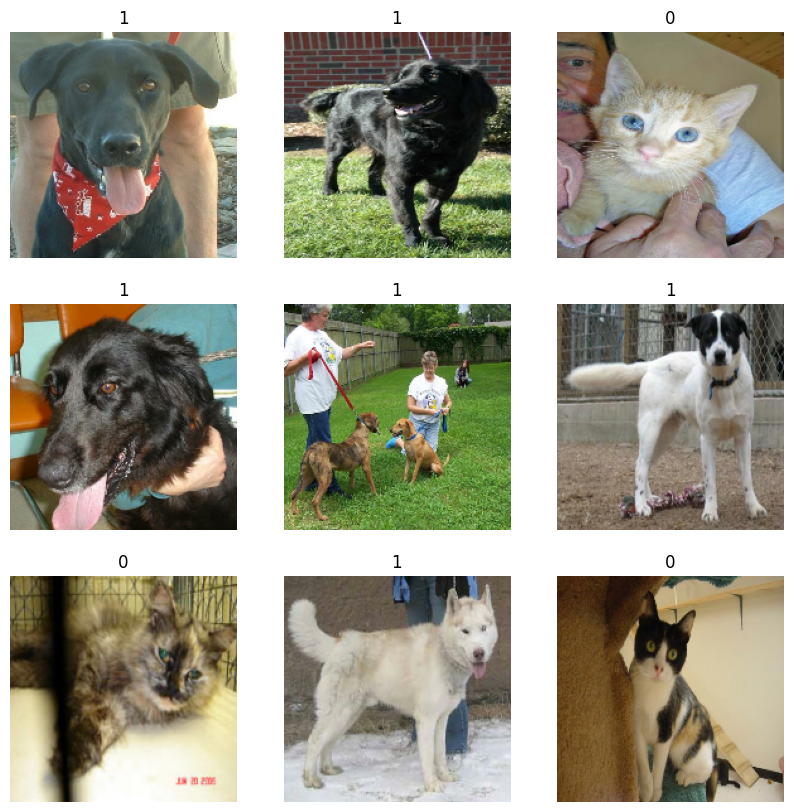

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

# Data Augumentation

In [12]:
augumentation_layers = [
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
]

def data_augumentation(images):
  for layer in augumentation_layers:
    images = layer(images)

  return images

# Augumented Images

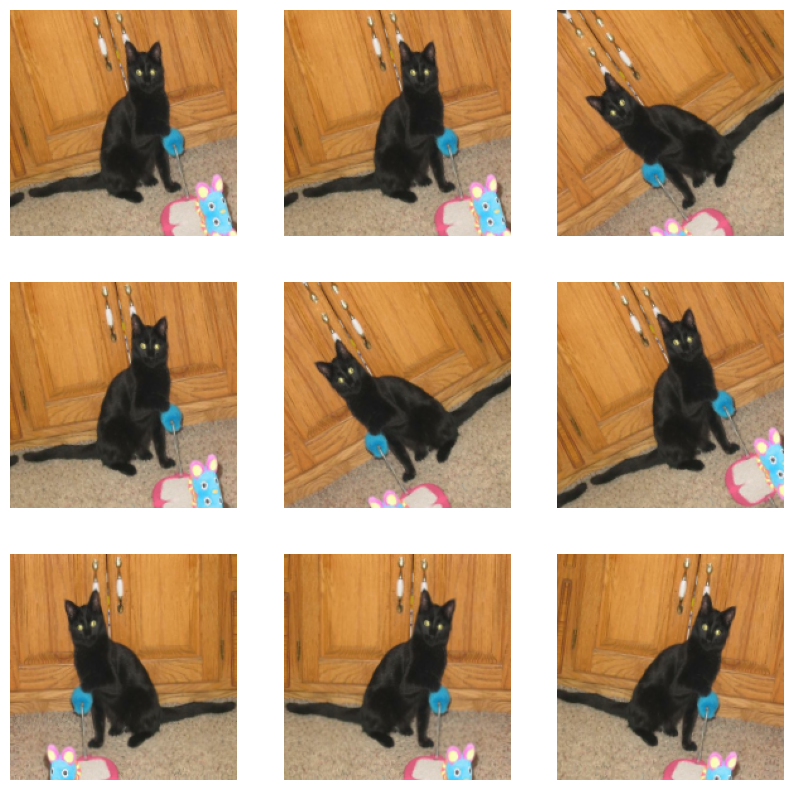

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augumented_images = data_augumentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augumented_images[0]).astype('uint8'))
        plt.axis('off')

# Performance Improvement

In [14]:
train_ds = train_ds.map(
    lambda img, label: (data_augumentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Xception Network (small version)

In [15]:
def model_creator(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  x = keras.layers.Rescaling(1./255)(inputs)
  x = keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)

  previous_block_activation = x

  for size in [256, 512, 728]:
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.SeparableConv2D(size, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)
    x = keras.layers.SeparableConv2D(size, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = keras.layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.add([x, residual])

    previous_block_activation = x

  x = keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)

  x = keras.layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    units = 1
  else:
    units = num_classes

  x = keras.layers.Dropout(0.25)(x)
  outputs = keras.layers.Dense(units, activation=None)(x)

  return keras.Model(inputs, outputs)

# TPU strategy scope

In [17]:
with strategy.scope():
  model = model_creator(input_shape=(180, 180, 3), num_classes=2)
  model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Train the model

In [18]:
model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 129s 491ms/step - acc: nan - loss: nan - val_acc: 0.5031 - val_loss: 0.6972
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 377ms/step - acc: nan - loss: nan - val_acc: 0.5031 - val_loss: 0.6936
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - acc: nan - loss: nan - val_acc: 0.5864 - val_loss: 0.7148
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 366ms/step - acc: nan - loss: nan - val_acc: 0.5048 - val_loss: 0.6880
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 60s 377ms/step - acc: nan - loss: nan - val_acc: 0.8338 - val_loss: 0.3417
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - acc: nan - loss: nan - val_acc: 0.6677 - val_loss: 0.6951
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 373ms/step - acc: nan - loss: nan - val_acc: 0.8630 - val_loss: 0.4043
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 365ms/step - acc: nan - loss: nan - val_acc: 0.9116 - val_loss: 0.2119
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - acc: nan - loss: nan -

# Save the trained Model

In [19]:
model.save('model.h5')

In [20]:
model.save('model.keras')

# Inference on new data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
-6.535468
This is a Cat


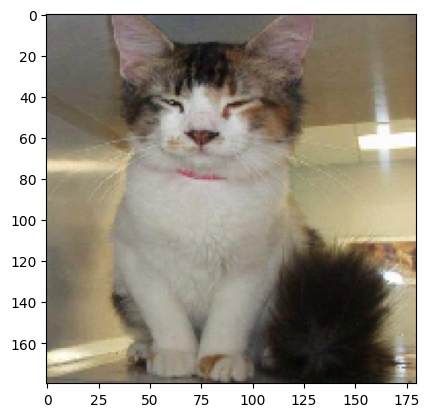

In [34]:
img = keras.utils.load_img('PetImages/Cat/733.jpg', target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = float(tf.sigmoid(predictions[0][0]))

print(predictions[0][0])
cat_score = 1 - score
if cat_score > score:
  print('This is a Cat')
else:
  print('This is a Dog')

In [35]:
!git clone git@github.com:madhavpani/Cat_vs_Dog.git

Cloning into 'Cat_vs_Dog'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
